In [1]:
import sys
import os
#add local dictionary to path
sys.path.append(os.path.dirname(os.path.abspath('')))

import random
import time
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

from joblib import dump, load

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

%matplotlib notebook
import matplotlib.pyplot as plt

'''Change Size of jupyter notebook'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from helpers.RtdRay import RtdRay
from dask.distributed import Client, LocalCluster
#start dask
client = Client(n_workers = 4)

## Read Data

In [3]:
dataset = pd.read_csv('../cache/parsed_obstacles2.csv')

/home/dm/tcp/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (42,43,45,46,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
dataset = dataset.drop('Unnamed: 0', axis=1) # .index.rename('grade'
dataset.reset_index(inplace=True, drop=True)

In [5]:
dataset.head()

,hash_id,id,dayly_id,date_id,stop_id,f,t,o,c,n,...,distance_to_next,distance_to_end,ar_pde,dp_ps,ar_ps,ar_dc,ar_tra,dp_tra,dp_dc,dp_cde
0,4968288888962560499,3778695356863398992-2102141952-13,3778695356863398992,2021-02-14 19:52:00,13,F,p,80,ICE,947,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-6223031425108996384,-3311445575526622346-2102142301-18,-3311445575526622346,2021-02-14 23:01:00,18,N,p,OWRE2,RE,63997,...,3014.113900,122613.720716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-2989495336375267595,7414978580161380141-2102150009-1,7414978580161380141,2021-02-15 00:09:00,1,F,p,80,ICE,948,...,7711.781651,868512.367485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5638705940724827892,-2451771813568964797-2102141948-10,-2451771813568964797,2021-02-14 19:48:00,10,F,p,80,ICE,957,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-4392794351789183379,5497688990211627963-2102150015-1,5497688990211627963,2021-02-15 00:15:00,1,N,p,800154,RE,3743,...,3014.113900,105036.620671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
len(dataset)

41234

In [7]:
dates = ['date_id', 'ar_ct', 'dp_ct', 'ar_pt', 'dp_pt','ar_clt', 'dp_clt']
for column in dates:
    dataset[column] = pd.to_datetime(dataset[column], errors='coerce')

In [3]:
rtd_d = RtdRay(notebook = True)

In [11]:
rtd = dataset
rtd['pp'] = rtd['ar_pp'].fillna(value=rtd['dp_pp'])
rtd = rtd.drop(columns=['ar_pp', 'dp_pp'], axis=0)

rtd = rtd_d._get_delays(rtd)
#rtd = rtd_d._categorize(rtd)

In [12]:
dataset = rtd
#rtd_d._categorize(rtd_d.load_data())

In [4]:
rtd = rtd_d.load_data()

In [9]:
rtd['minute'] = rtd['ar_pt'].fillna(value=rtd['dp_pt'])
rtd['minute'] = (rtd['minute'].dt.minute + rtd['minute'].dt.hour * 60).astype('int16')
rtd['day'] = rtd['ar_pt'].fillna(value=rtd['dp_pt']).dt.dayofweek.astype('int8')
rtd['stay_time'] = ((rtd['dp_pt'] - rtd['ar_pt']).dt.seconds // 60) #.astype('Int16')

# Label encode categorical columns
categoricals = ['o', 'c', 'n', 'station', 'pp']
# categoricals.extend(['ar_cs', 'dp_cs'])
for key in categoricals:
    # dd.read_parquet reads categoricals as unknown categories. All the categories however get
    # saved in each partition. So we read those and set them as categories for the whole column.
    # https://github.com/dask/dask/issues/2944 
    rtd[key] = rtd[key].cat.set_categories(rtd[key].head(1).cat.categories)

    # rtd[key] = rtd[key].cat.codes.astype('int16')
rtd['stop_id'] = rtd['stop_id'].astype('int16')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
dataset = rtd.dropna()
dataset.columns

In [5]:
dataset.head(10)

NameError: name 'dataset' is not defined

### Balance Data Func

In [13]:
def balance(dset, label, random_state):
    # make the balance of delayed trains in the dataset better
    #split dataset
    minor = dset[dset[label]] 
    major = dset[~dset[label]]
    #set major dataset to lenght of minor dataset by randomly seletcting datapoints
    major = major.sample(n=len(minor),random_state=random_state)
    #combine datsets
    balancedset = pd.concat([minor, major], ignore_index=True, sort=False)
    #I think this shuffels? and ensure length
    balancedset = balancedset.sample(n=len(balancedset),random_state=random_state).reset_index(drop=True)
    #print(len(balancedset))
    return balancedset

## Create training data

In [33]:
label = 'ar_delay_bool'
# feat_labels= ['station', 'lat', 'lon', 'o', 'c', 'n', 'distance_to_start',
#        'distance_to_end', 'pp', 'stop_id', 'minute',
#        'day', 'stay_time']
feat_labels= ['station', 'o', 'c', 'n', 'distance_to_start',
       'distance_to_end', 'pp', 'stop_id','category_sum',
       'priority_sum', 'total_length', 'obstacle_no']
dataset[label] = dataset['ar_delay'] > 3.0

In [54]:
# Convert to pandas(we have the ram)
# dataset_pd = dataset.compute()
dataset_pd = dataset[[*feat_labels, label, 'ar_delay' , 'dp_delay']].dropna(subset=['ar_delay'])

In [ ]:
# Only data with obstacles
dataset_pd = dataset_pd[dataset_pd['obstacle_no'] != 0]

In [55]:
from sklearn.preprocessing import LabelEncoder

dataset_pd[['station','o','c','pp']] = dataset_pd[['station','o','c','pp']].apply(LabelEncoder().fit_transform)

In [56]:
dataset_pd.loc[dataset_pd['total_length'] != 0, 'ar_delay'].mean()

3.819327731092437

In [57]:
dataset_pd.loc[dataset_pd['total_length'] == 0, 'ar_delay'].mean()

2.624147211616699

### Split data

In [78]:
random_state = random.randint(1, 1000)

In [79]:
# df = dataset.sample(frac=1,random_state=random_state)
X = dataset_pd[feat_labels]
y = dataset_pd[label]
#del df
print('SplitDataset')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

SplitDataset


In [80]:
#and nowxt with balanced
print('BalanceDataset')
#dataset_bal = balance(dataset, label, random_state)
dataset_bal = X_train.copy()
dataset_bal[label] = y_train.copy()
dataset_bal = balance(dataset_bal, label, random_state)
X_bal = dataset_bal[feat_labels]
y_bal = dataset_bal[label]

print('SplitBalanceDataset')
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.1, random_state=random_state)

BalanceDataset
SplitBalanceDataset


## Testing

In [81]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

'''Define your models here'''
models = {}
models['zeroR'] = DummyClassifier(strategy="most_frequent", random_state=random_state)
# models['RandomForest'] = RandomForestClassifier(n_estimators=len(feat_labels)-2, max_depth=12, n_jobs=-1,random_state=random_state),
# models['DecisionTree'] = DecisionTreeClassifier(max_depth = 12, random_state=random_state)
models['RandomForest'] = RandomForestClassifier(n_estimators=10, max_depth = 4, n_jobs=-1,random_state=random_state)
models['ExtraTrees'] = ExtraTreesClassifier(n_estimators=10, max_depth = 4, n_jobs=-1,random_state=random_state)
# models['XGBoost'] = XGBClassifier(n_estimators=74, max_depth=14, gamma=2.4198827941782633e-08,  learning_rate=0.21905465538567,  n_jobs=-1, objective='binary:logistic', random_state=random_state)
# models['XGBoost2'] = XGBClassifier(n_estimators=128, max_depth=12, n_jobs=-1, objective='binary:logistic', random_state=random_state)
# models['2_ar'] = XGBClassifier(n_estimators=64, max_depth=10, gamma=0.0038991257380264015,  learning_rate=0.23765037213409665,  n_jobs=-1, objective='binary:logistic', random_state=random_state)
# models['5_ar'] = XGBClassifier(n_estimators=29, max_depth=6, gamma=0.005487290168001119,  learning_rate=0.02065637644183924 ,  n_jobs=-1, objective='binary:logistic', random_state=random_state)

infos = pd.DataFrame()
infos = infos.append(pd.Series({'acc': random_state}, name="random_state"))

In [82]:
def train_and_test(model_name, X_tr, y_tr, X_te, y_te, cross_val = False):
    global infos
    
    s = pd.Series(name = model_name, dtype=pd.StringDtype())
    if False:
        scores = cross_val_score(models[model_name], X, y, cv=StratifiedKFold(n_splits=5))
        s['cross_val_strat'] = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)
    
    if cross_val:
        print("        Cross Val")
        scores = cross_val_score(models[model_name], X, y, cv=5)    
        s['cross_val'] = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)
    
    print("        Normal")
    models[model_name].fit(X_tr, y_tr)
    model_classified = models[model].predict(X_te)
    s['acc'] = 1 - ((y_te != model_classified).sum() / X_te.shape[0])

    s['conf_matrix'] = confusion_matrix(y_te, model_classified, labels=[0,1])
        
    infos = infos.append(s)

for model in models.copy().keys():
    print(model)
    
    print("    Normal")
    train_and_test(model,X_train, y_train, X_test, y_test, True)
    
    print("    Balanced")
    models[model + '_bal']  = models[model]
    train_and_test(model + '_bal', X_train_bal, y_train_bal, X_test_bal, y_test_bal, True)
    
#     print("    Balanced train, Unbalanced Test")
#     models[model + '_btut']  = models[model]
#     train_and_test(model + '_btut', X_train_bal, y_train_bal, X_test, y_test)
    
    
    
    #for feature in zip(feat_labels, models[model].feature_importances_):
    #   print(feature)

zeroR
    Normal
        Cross Val
        Normal
    Balanced
        Cross Val
        Normal
RandomForest
    Normal
        Cross Val
        Normal
    Balanced
        Cross Val
        Normal
ExtraTrees
    Normal
        Cross Val
        Normal
    Balanced
        Cross Val
        Normal


In [83]:
print(infos.to_markdown())

|                  |        acc | conf_matrix   | cross_val                 |
|:-----------------|-----------:|:--------------|:--------------------------|
| random_state     | 344        | nan           | nan                       |
| zeroR            |   0.828589 | [[2707    0]  | Accuracy: 0.84 (+/- 0.00) |
|                  |            |  [ 560    0]] |                           |
| zeroR_bal        |   0.499476 | [[  0 478]    | Accuracy: 0.84 (+/- 0.00) |
|                  |            |  [  0 477]]   |                           |
| RandomForest     |   0.828895 | [[2705    2]  | Accuracy: 0.53 (+/- 0.54) |
|                  |            |  [ 557    3]] |                           |
| RandomForest_bal |   0.667016 | [[279 199]    | Accuracy: 0.53 (+/- 0.54) |
|                  |            |  [119 358]]   |                           |
| ExtraTrees       |   0.828589 | [[2707    0]  | Accuracy: 0.78 (+/- 0.14) |
|                  |            |  [ 560    0]] |               

In [ ]:
models_old = models

## ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(actual, preds):
    fpr, tpr, thresholds = roc_curve(actual, preds[:,1])
    plt.plot(fpr, tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
    plt.show()

In [ ]:
plot_roc_auc(y_test, DummyClassifier(strategy="most_frequent").fit( X_train,y_train).predict_proba(X_test))
#plot_roc_auc(y_test, models['RandomForest'].predict_proba(X_test))
# for model in models:
#     print(model)
plot_roc_auc(y_test, models['XGBoost'].predict_proba(X_test))
plot_roc_auc(y_test, models['RandomForest'].predict_proba(X_test))
plt.show()

## Some other stuff

In [ ]:
data = dataset_pandas.groupby(['o'])['ar_delay']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(data.index, data)
plt.show()

In [ ]:
grouped_data['ar_delay'].mean().iloc[:30].sort_values(ascending=False)

In [ ]:
grouped_data =  dataset_pandas.groupby(['o'])
N = 100
ar_means = grouped_data['ar_delay'].mean().iloc[:N]
ar_std = grouped_data['ar_delay'].std().iloc[:N]

ind = np.arange(N)  # the x locations for the groups
width = 1       # the width of the bars

fig, ax = plt.subplots()
ax.set_xlim(0, int(max(ar_means.values)))
rects1 = ax.barh(ind, ar_means, width, color='r')

# dp_means = grouped_data['dp_delay'].mean().iloc[:N]
# dp_std = grouped_data['dp_delay'].std().iloc[:N]
# rects2 = ax.barh(ind + width, dp_means, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores')
ax.set_yticks(ind + width / 2)
plt.yticks(range(N), ar_means.index, size='small')

# ax.legend((rects1[0], rects2[0]), ('a_delay', 'd_delay'))

plt.show()

## Define your Feature names here

In [44]:
rename = {'station': 'Station',
 'lat': 'Breitengrad',
 'lon': 'Längengrad',
 'o': 'Betreiber',
 'c': 'Zugtyp',
 'n': 'Zugnummer',
 'distance_to_start': 'Distanz zum Startbahnhof',
 'distance_to_end': 'Distanz zum Endbahnhof',
 'pp': 'Gleis',
 'stop_id': 'Halt Nummer',
 'minute': 'Minute',
 'day': 'Wochentag',
 'stay_time': 'Wartezeit',
 'ar_delay': 'Ankunfts Verspätung',
 'dp_delay': 'Abfahrts Verspätung'}

## Correlation

In [45]:
def corr_matrix(df):
    corr = df.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(df.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.columns)
    plt.show()

<IPython.core.display.Javascript object>


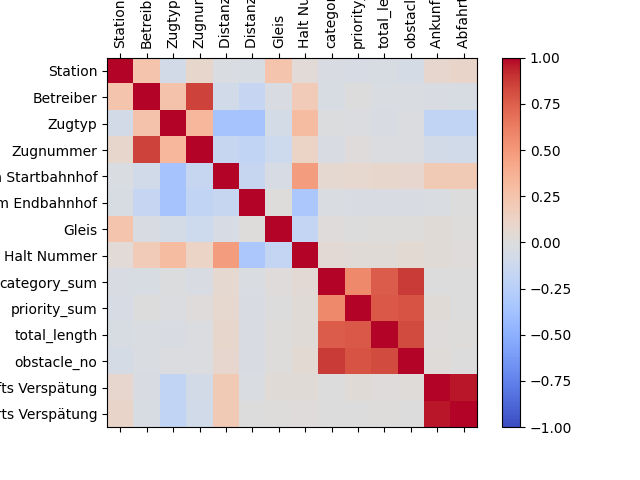

In [64]:
corr_matrix(dataset_pd.rename(columns=rename).drop('ar_delay_bool', axis=1))

## Freature Importance

In [47]:
import seaborn as sns
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances, model_name):
    df = pd.DataFrame({'feature': column_names,
                       model_name: importances}).reset_index(drop = True)
    return df.set_index('feature')

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    a4_dims = (11.7, 6)
    fig, ax = plt.subplots()
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    sns.barplot(ax=ax ,x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue').set_title(title, fontsize = 20)
    plt.plot()

In [65]:
feat_imp = pd.DataFrame(index=X_train.columns) #.rename(columns=rename)
for model in ['RandomForest', 'ExtraTrees', 'XGBoost']:
    try:
        feat_imp = pd.concat([feat_imp, imp_df(X_train.columns, models[model].feature_importances_, model)],axis=1)
    except:
        pass
feat_imp = feat_imp.reindex(feat_imp.mean(axis=1).sort_values().index).rename(index=rename)

In [66]:
feat_imp

,RandomForest,ExtraTrees
category_sum,0.002227,0.003419
obstacle_no,0.002986,0.004137
priority_sum,0.003819,0.004291
total_length,0.004073,0.004322
Halt Nummer,0.077186,0.065837
Betreiber,0.074707,0.080289
Gleis,0.085642,0.072436
Distanz zum Endbahnhof,0.120179,0.071137
Zugtyp,0.096491,0.153820
Distanz zum Startbahnhof,0.160524,0.161387


<IPython.core.display.Javascript object>


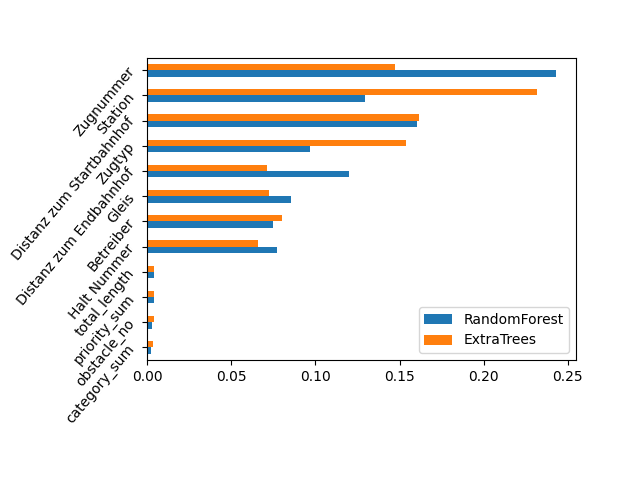

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [67]:
# fig, ax = plt.subplots(1)
ax = feat_imp.plot.barh()
#ax.set_xticklabels(feat_imp.index, rotation=45, fontsize=10)
plt.subplots_adjust(left=0.23,hspace=0, bottom=0.25)
#doesn't crash, but does not rotate the xticks
#plt.xticks(rotation=70)
plt.setp(plt.yticks()[1], rotation=50, ha='right')

In [ ]:
#base_imp = imp_df(X_train.rename(columns=rename).columns, models['RandomForest'].feature_importances_)
base_imp = imp_df(X_train.columns, models['RandomForest'].feature_importances_)
base_imp.plot.barh()

In [ ]:
feat_imp = []
for model in models:
    feat_imp.append(feat_impimp_df(X_train.columns, models[model].feature_importances_))

index = 

df = pd.DataFrame({'feature importance': speed})
>>> ax = df.plot.barh()

In [ ]:
ax = plt.subplot(111)
ax.bar(imp_df(X_train.columns, models['RandomForest'].feature_importances_), width=0.2, color='b', align='center')
ax.bar(imp_df(X_train.columns, models['ExtraTrees'].feature_importances_), width=0.2, color='g', align='center')

plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
result = permutation_importance(models['RandomForest'], X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

In [ ]:
a4_dims = (11.7, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
def explore_tree(estimator, n_nodes, children_left,children_right, feature,threshold,
                suffix='', print_tree= False, sample_id=0, feature_names=None):

    if not feature_names:
        feature_names = feature


    assert len(feature_names) == X.shape[1], "The feature names do not match the number of features."
    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %s nodes"
          % n_nodes)
    if print_tree:
        print("Tree structure: \n")
        for i in range(n_nodes):
            if is_leaves[i]:
                print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
            else:
                print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
                      "node %s."
                      % (node_depth[i] * "\t",
                         i,
                         children_left[i],
                         feature[i],
                         threshold[i],
                         children_right[i],
                         ))
            print("\n")
        print()

    # First let's retrieve the decision path of each sample. The decision_path
    # method allows to retrieve the node indicator functions. A non zero element of
    # indicator matrix at the position (i, j) indicates that the sample i goes
    # through the node j.

    node_indicator = estimator.decision_path(X_test)

    # Similarly, we can also have the leaves ids reached by each sample.

    leave_id = estimator.apply(X_test)

    # Now, it's possible to get the tests that were used to predict a sample or
    # a group of samples. First, let's make it for the sample.

    #sample_id = 0
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]

    print(X_test[sample_id,:])

    print('Rules used to predict sample %s: ' % sample_id)
    for node_id in node_index:
        # tabulation = " "*node_depth[node_id] #-> makes tabulation of each level of the tree
        tabulation = ""
        if leave_id[sample_id] == node_id:
            print("%s==> Predicted leaf index \n"%(tabulation))
            #continue

        if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print("%sdecision id node %s : (X_test[%s, '%s'] (= %s) %s %s)"
              % (tabulation,
                 node_id,
                 sample_id,
                 feature_names[feature[node_id]],
                 X_test[sample_id, feature[node_id]],
                 threshold_sign,
                 threshold[node_id]))
    print("%sPrediction for sample %d: %s"%(tabulation,
                                          sample_id,
                                          estimator.predict(X_test)[sample_id]))

    # For a group of samples, we have the following common node.
    sample_ids = [sample_id, 1]
    common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                    len(sample_ids))

    common_node_id = np.arange(n_nodes)[common_nodes]

    print("\nThe following samples %s share the node %s in the tree"
          % (sample_ids, common_node_id))
    print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

    for sample_id_ in sample_ids:
        print("Prediction for sample %d: %s"%(sample_id_,
                                          estimator.predict(X_test)[sample_id_]))

In [ ]:
for i,e in enumerate(estimator.estimators_):

    print("Tree %d\n"%i)
    explore_tree(estimator.estimators_[i],n_nodes_[i],children_left_[i],
                 children_right_[i], feature_[i],threshold_[i],
                suffix=i, sample_id=1, feature_names=["Feature_%d"%i for i in range(X.shape[1])])
    print('\n'*2)

In [ ]:
from sklearn import tree
import graphviz

clf = estimator.estimators_[0]

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=["False", "True"],  
                                filled=True, rounded=True,  
                                special_characters=True)  

In [ ]:
import graphviz
from IPython.display import display

In [ ]:
graph = graphviz.Source(dot_data)

In [ ]:
graph.render("tree.pdf")

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

In [ ]:
iris.feature_names

In [ ]:
iris.target_names

!sudo apt install graphviz --y